# 0 Initialise

### Import Packages

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mimic_constants import *
from os import makedirs
from xgboost import XGBClassifier
from CardiomegalyBiomarkers.Cardiomegaly_Classification.src.xgboost_functions import SplitData, train_test_xgboost

/home/ays124/mimic/venv/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


### Paths

In [2]:
# Path for model location and error graphs
model_folder = 'CardiomegalyBiomarkers/Cardiomegaly_Classification/models/xgboost_impute/'
makedirs(model_folder, exist_ok=True)

### Model Parameters

In [3]:
# Data parameters
TrainTestFractions = [0.9, 0.1] # Spits of data for training/validation and testing sets
FoldFractions = [0.2, 0.2, 0.2, 0.2, 0.2] # Spits of data for folds

# XGBoost parameters
eval_metric = 'logloss'
scale_pos_weight = 0.3/0.7
colsample_bytree = 0.75
gamma = 0
lr = 0.1
subsample = 0.75

max_depth_shallow = 3
max_depth_deep = 8

early_stopping = 15

In [4]:
# Feature selection for model
base = ['subject_id', 'hadm_id', 'stay_id', 'path'] # base features

vital = ['HR_mean', 'ABPs_mean', 'ABPd_mean', 'ABPm_mean', 'NBPs_mean', 'NBPd_mean',  # vital sign features (V)
         'NBPm_mean', 'RR_mean', 'PO2_mean', 'SaO2_mean', 'PCO2_mean', 'PH_mean', 'SpO2_mean', 
         'Cholesterol_mean', 'Sodium_mean', 'Temp(F)_mean', 'FiO2_mean', 'Albumin_mean', 
         'PlateletCount_mean', 'HR_max', 'ABPs_max', 'ABPd_max', 'ABPm_max', 'NBPs_max', 
         'NBPd_max', 'NBPm_max', 'RR_max', 'PCO2_max', 'Sodium_max', 'FiO2_max', 'HR_min', 
         'ABPs_min', 'ABPd_min', 'ABPm_min', 'NBPs_min', 'NBPd_min', 'NBPm_min', 'RR_min', 
         'PCO2_min', 'SpO2_min', 'Sodium_min']


lab = ['Hemoglobin_mean', 'Lactate_mean', 'Tidal_Volume_mean', 'ALT_mean', 'Alkaline_Phosphatase_mean', # laboratory features (L)
       'Bilirubin', 'Calcium_Total_mean', 'Chloride_mean', 'Creatinine_mean', 'Glucose_mean', 
       'Magnesium_mean', 'Phosphate_mean', 'Potassium_mean', 'Troponin-T_mean', 'Urea_Nitrogren_mean', 
       'Fibrinogen', 'Hematocrit_mean', 'PTT_mean', 'WBC_mean', 'Hemoglobin_max', 'Potassium_max', 
       'Troponin-T_max', 'WBC_max', 'Hemoglobin_min', 'Potassium_min', 'WBC_min']

meta_cont = ['los', 'anchor_age']                # continuous metadata features (M)
meta_cat = ['gender']                            # categorical metadata features (M)
meta_cat_encoded = ['gender_F', 'gender_M']      # encoded catgeorical metadata features

bmrks = ['CTR', 'CPAR']     # biomarker features (BMRK)

# 1 Data Prepocessing

In [5]:
# Read 
data = get_master_df(idp=True)

# Change name of column to indicate class deoaration
data.rename(columns={'Cardiomegaly':'class'}, inplace=True)

In [6]:
df = data
select_col_groups = []
removed_col_groups = []
og_col_groups = [chart_labels_mean_cols, chart_labels_max_cols, chart_labels_min_cols, lab_labels_mean_cols, lab_labels_max_cols, lab_labels_min_cols]
for col_group in og_col_groups:
    nan_counts = data[col_group].isna().sum()
    too_many_nans = nan_counts[nan_counts > 1000].index.tolist()
    df = df.drop(too_many_nans, axis=1)
    col_group = list(set(col_group) - set(too_many_nans))
    select_col_groups.append(col_group)
    removed_col_groups.append(too_many_nans)
    vital = [item for item in vital if item not in too_many_nans]
    lab = [item for item in lab if item not in too_many_nans]

In [7]:
select_col_groups = [j for sub in select_col_groups for j in sub] + ['CTR', 'CPAR']

In [8]:
study_year = np.floor(df['StudyDate'] / 10000)
delta_years = study_year - df['anchor_year']
df['anchor_age'] = df['anchor_age'] + delta_years

In [9]:
# Select modality combinations tested (list of lists)
modalities_combinations = [[vital + lab + meta_cont + meta_cat_encoded, 'M_L_V'],
                           [bmrks, 'BMRK'], 
                           [vital + lab + meta_cont + meta_cat_encoded + bmrks, 'M_L_V_BMRK']]

In [10]:
[TrainVal_df, Test_df] = SplitData(df, TrainTestFractions)

# Split trainval into folds
[Fold1_df, Fold2_df, Fold3_df, Fold4_df, Fold5_df] = SplitData(TrainVal_df, FoldFractions)

In [11]:
# Preprocess folds for xgboost use by selecting features and encoding categorical features
Fold1_df = pd.concat([Fold1_df[base + vital + lab + meta_cont + bmrks], pd.get_dummies(Fold1_df[meta_cat]), Fold1_df['class']], axis=1)
Fold2_df = pd.concat([Fold2_df[base + vital + lab + meta_cont + bmrks], pd.get_dummies(Fold2_df[meta_cat]), Fold2_df['class']], axis=1)
Fold3_df = pd.concat([Fold3_df[base + vital + lab + meta_cont + bmrks], pd.get_dummies(Fold3_df[meta_cat]), Fold3_df['class']], axis=1)
Fold4_df = pd.concat([Fold4_df[base + vital + lab + meta_cont + bmrks], pd.get_dummies(Fold4_df[meta_cat]), Fold4_df['class']], axis=1)
Fold5_df = pd.concat([Fold5_df[base + vital + lab + meta_cont + bmrks], pd.get_dummies(Fold5_df[meta_cat]), Fold5_df['class']], axis=1)

# Preprocess test set for xgboost use by selecting features and encoding categorical features
Test_df = pd.concat([Test_df[base + vital + lab + meta_cont + bmrks], pd.get_dummies(Test_df[meta_cat]), Test_df['class']], axis=1)

# 2 Model Training and Testing

[0]	validation_0-logloss:0.51123	validation_1-logloss:0.52797
[0]	validation_0-logloss:0.51123	validation_1-logloss:0.52797
[1]	validation_0-logloss:0.49232	validation_1-logloss:0.52245
[1]	validation_0-logloss:0.49232	validation_1-logloss:0.52245
[2]	validation_0-logloss:0.47314	validation_1-logloss:0.51539
[2]	validation_0-logloss:0.47314	validation_1-logloss:0.51539
[3]	validation_0-logloss:0.45805	validation_1-logloss:0.50484
[3]	validation_0-logloss:0.45805	validation_1-logloss:0.50484
[4]	validation_0-logloss:0.44428	validation_1-logloss:0.49795
[4]	validation_0-logloss:0.44428	validation_1-logloss:0.49795
[5]	validation_0-logloss:0.42816	validation_1-logloss:0.49352
[5]	validation_0-logloss:0.42816	validation_1-logloss:0.49352
[6]	validation_0-logloss:0.41545	validation_1-logloss:0.49079


[6]	validation_0-logloss:0.41545	validation_1-logloss:0.49079
[7]	validation_0-logloss:0.40486	validation_1-logloss:0.48965
[7]	validation_0-logloss:0.40486	validation_1-logloss:0.48965
[8]	validation_0-logloss:0.39298	validation_1-logloss:0.48764
[8]	validation_0-logloss:0.39298	validation_1-logloss:0.48764
[9]	validation_0-logloss:0.38120	validation_1-logloss:0.48578
[9]	validation_0-logloss:0.38120	validation_1-logloss:0.48578
[10]	validation_0-logloss:0.37255	validation_1-logloss:0.48511
[10]	validation_0-logloss:0.37255	validation_1-logloss:0.48511
[11]	validation_0-logloss:0.36202	validation_1-logloss:0.48116
[11]	validation_0-logloss:0.36202	validation_1-logloss:0.48116
[12]	validation_0-logloss:0.35196	validation_1-logloss:0.48153
[12]	validation_0-logloss:0.35196	validation_1-logloss:0.48153
[13]	validation_0-logloss:0.34365	validation_1-logloss:0.48008
[13]	validation_0-logloss:0.34365	validation_1-logloss:0.48008
[14]	validation_0-logloss:0.33390	validation_1-logloss:0.47816

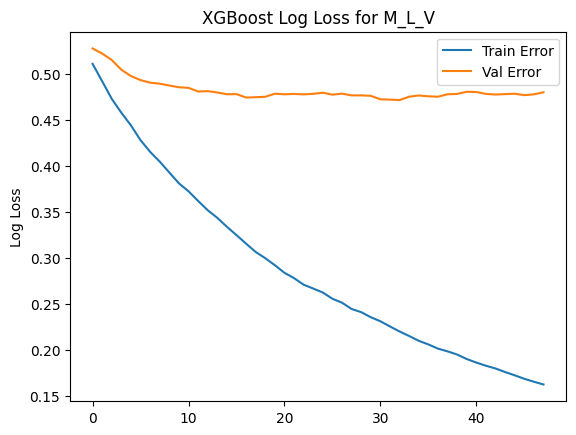

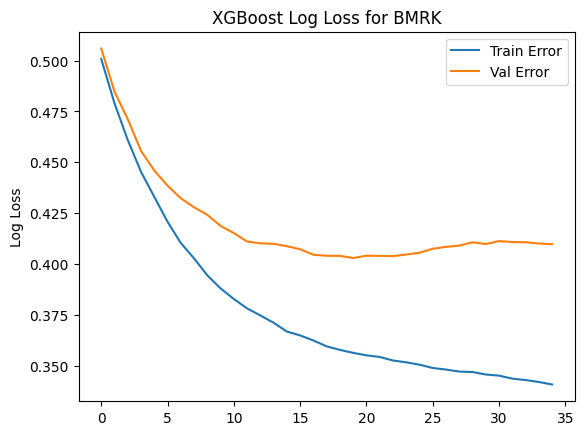

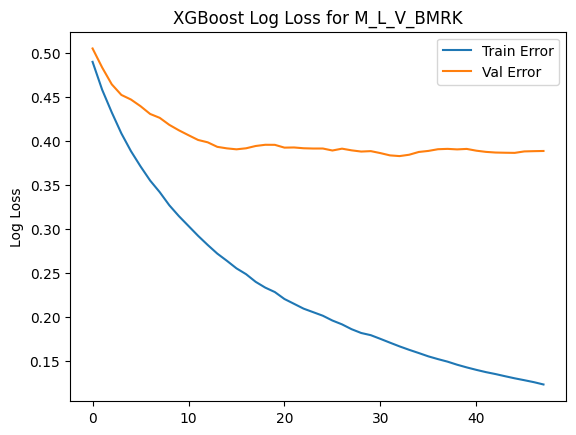

In [12]:
# define dict of model parameters
model_params = {'eval_metric' : eval_metric,
                'scale_pos_weight' : scale_pos_weight,
                'colsample_bytree' : colsample_bytree,
                'gamma' : gamma,
                'lr' : lr,
                'subsample' : subsample, 
                'max_depth_shallow' : max_depth_shallow,
                'max_depth_deep' : max_depth_deep,
                'early_stopping' : early_stopping}


# getmodels, train and test, return pandas of results using k-fold cross validation
# -> if lossFigure and saveModels are True, then figures of training and validation losses and models are saved in ./MOdel/xgboost/
results_fold1 = train_test_xgboost([Fold2_df, Fold3_df, Fold4_df, Fold5_df], Fold1_df, 1, Test_df, modalities_combinations, model_params, model_folder, lossFigure = True, exportModels = True , select_col_groups=select_col_groups, impute=True)
results_fold2 = train_test_xgboost([Fold1_df, Fold3_df, Fold4_df, Fold5_df], Fold2_df, 2, Test_df, modalities_combinations, model_params, model_folder, lossFigure = False, exportModels = True, select_col_groups=select_col_groups, impute=True)
results_fold3 = train_test_xgboost([Fold2_df, Fold1_df, Fold4_df, Fold5_df], Fold3_df, 3, Test_df, modalities_combinations, model_params, model_folder, lossFigure = False, exportModels = True, select_col_groups=select_col_groups, impute=True)
results_fold4 = train_test_xgboost([Fold2_df, Fold3_df, Fold1_df, Fold5_df], Fold4_df, 4, Test_df, modalities_combinations, model_params, model_folder, lossFigure = False, exportModels = True, select_col_groups=select_col_groups, impute=True)
results_fold5 = train_test_xgboost([Fold2_df, Fold3_df, Fold4_df, Fold1_df], Fold5_df, 5, Test_df, modalities_combinations, model_params, model_folder, lossFigure = False, exportModels = True, select_col_groups=select_col_groups, impute=True)


In [13]:
# These lines are inlcuded to show how to load an exported xgboost model for predictions on new data
'''
model_load = XGBClassifier()
model_load.load_model(model_folder + 'BMRK_fold1_model.json')
'''

"\nmodel_load = XGBClassifier()\nmodel_load.load_model(model_folder + 'BMRK_fold1_model.json')\n"

# 3 Results Analysis

In [14]:
# display results per fold
print(f'#######   VAL FOLD: fold 1   ########')
display(results_fold1)

print(f'#######   VAL FOLD: fold 2   ########')
display(results_fold2)

print(f'#######   VAL FOLD: fold 3   ########')
display(results_fold3)

print(f'#######   VAL FOLD: fold 4   ########')
display(results_fold4)

print(f'#######   VAL FOLD: fold 5   ########')
display(results_fold5)

#######   VAL FOLD: fold 1   ########


,Accuracy,ROC AUC,F1 score,Confusion Matrix
Modalities,,,,
M_L_V,0.805970,0.564204,0.235294,"[[104, 1], [25, 4]]"
BMRK,0.783582,0.562397,0.256410,"[[100, 5], [24, 5]]"
M_L_V_BMRK,0.798507,0.634319,0.425532,"[[97, 8], [19, 10]]"


#######   VAL FOLD: fold 2   ########


,Accuracy,ROC AUC,F1 score,Confusion Matrix
Modalities,,,,
M_L_V,0.798507,0.546962,0.181818,"[[104, 1], [26, 3]]"
BMRK,0.791045,0.579639,0.300000,"[[100, 5], [23, 6]]"
M_L_V_BMRK,0.798507,0.634319,0.425532,"[[97, 8], [19, 10]]"


#######   VAL FOLD: fold 3   ########


,Accuracy,ROC AUC,F1 score,Confusion Matrix
Modalities,,,,
M_L_V,0.783582,0.500000,0.000000,"[[105, 0], [29, 0]]"
BMRK,0.783582,0.562397,0.256410,"[[100, 5], [24, 5]]"
M_L_V_BMRK,0.805970,0.639080,0.434783,"[[98, 7], [19, 10]]"


#######   VAL FOLD: fold 4   ########


,Accuracy,ROC AUC,F1 score,Confusion Matrix
Modalities,,,,
M_L_V,0.776119,0.520197,0.117647,"[[102, 3], [27, 2]]"
BMRK,0.791045,0.579639,0.300000,"[[100, 5], [23, 6]]"
M_L_V_BMRK,0.813433,0.656322,0.468085,"[[98, 7], [18, 11]]"


#######   VAL FOLD: fold 5   ########


,Accuracy,ROC AUC,F1 score,Confusion Matrix
Modalities,,,,
M_L_V,0.783582,0.500000,0.000000,"[[105, 0], [29, 0]]"
BMRK,0.805970,0.626601,0.409091,"[[99, 6], [20, 9]]"
M_L_V_BMRK,0.820896,0.623645,0.400000,"[[102, 3], [21, 8]]"


In [15]:
# Average performance scores over 5 folds and split per feature used
results = pd.concat([results_fold1, results_fold2, results_fold3, results_fold4, results_fold5])

modalities = list(set(results.index.tolist()))

for modality in modalities:
    results_summary = pd.concat([results['Accuracy'].loc[modality].describe(), results['ROC AUC'].loc[modality].describe(), results['F1 score'].loc[modality].describe()], axis=1)
    results_summary.columns = ['Accuracy', 'ROC AUC', 'F1 score']
    print(f'#######   AVG OVER 5 FOLDS: {modality}    ########')
    display(results_summary.iloc[1:3])

#######   AVG OVER 5 FOLDS: M_L_V_BMRK    ########


,Accuracy,ROC AUC,F1 score
mean,0.807463,0.637537,0.430786
std,0.009730,0.011926,0.024547


#######   AVG OVER 5 FOLDS: BMRK    ########


,Accuracy,ROC AUC,F1 score
mean,0.791045,0.582135,0.304382
std,0.009140,0.026310,0.062460


#######   AVG OVER 5 FOLDS: M_L_V    ########


,Accuracy,ROC AUC,F1 score
mean,0.789552,0.526273,0.106952
std,0.012262,0.028654,0.106147


# 4 Feature Importance

In [16]:
model_load = XGBClassifier()
model_load.load_model(model_folder + 'M_L_V_fold1_model.json')
# Feature importances from the trained XGBoost model
feature_importances = model_load.feature_importances_
important_features = pd.DataFrame({
    'Feature': modalities_combinations[0][0],
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

important_features.head(10)

,Feature,Importance
38,anchor_age,0.052263
32,Urea_Nitrogren_mean,0.046915
20,SpO2_min,0.036739
39,gender_F,0.033694
4,RR_mean,0.032432
29,Magnesium_mean,0.029910
5,SpO2_mean,0.029889
22,ALT_mean,0.029414
40,gender_M,0.027550
26,Chloride_mean,0.027067


In [17]:
model_load = XGBClassifier()
model_load.load_model(model_folder + 'BMRK_fold1_model.json')
# Feature importances from the trained XGBoost model
feature_importances = model_load.feature_importances_
important_features = pd.DataFrame({
    'Feature': modalities_combinations[1][0],
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

important_features.head(10)

,Feature,Importance
0,CTR,0.644361
1,CPAR,0.355639


In [18]:
model_load = XGBClassifier()
model_load.load_model(model_folder + 'M_L_V_BMRK_fold2_model.json')
# Feature importances from the trained XGBoost model
feature_importances = model_load.feature_importances_
important_features = pd.DataFrame({
    'Feature': modalities_combinations[2][0],
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

important_features.head(12)

,Feature,Importance
42,CPAR,0.121792
41,CTR,0.096277
32,Urea_Nitrogren_mean,0.033773
13,RR_max,0.031420
27,Creatinine_mean,0.029704
39,gender_F,0.026572
4,RR_mean,0.024202
15,HR_min,0.022595
20,SpO2_min,0.022309
29,Magnesium_mean,0.022009
